# PyCitySchools Analysis - Surfs Up!

By Tim St. Onge


In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta, datetime
import re

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

In [10]:
# The first task in the homework is to find the date from a year ago today so that we can query the database...
#...for the past year's weather data.

currentDT = dt.datetime.now()
today_date = currentDT.date()
d = today_date - timedelta(days=365)

# However, since there are no data points in the past year, we instead will analyze the most recent 12 months...
#...of data in the database for this analysis.

In [11]:
# First, a database connection is established and then all of the data from the Measurement and Station...
#...tables in the SQLite database are read into dataframes:
conn = engine.connect()
measurements_df = pd.read_sql("SELECT * FROM measurement", conn)
stations_df = pd.read_sql("SELECT * FROM station", conn)

### Precipitation Analysis

In [12]:
# The precipitation analysis will first require use of the Measurements dataframe. The steps immediately below...
#...are designed to find the latest date in the dataset and the date one year before that latest date. Because...
#...the "date" information is stored as string in the dataframe, we also need to convert the column to "datetime"...
#...format.

# In a copied dataframe, sort the Measurements data by "date" in descending order and then select the first...
#...date value in that sorted list.
precip_df = measurements_df.sort_values('date', ascending=False)
last_date = precip_df['date'].iloc[0]

# Convert the stored latest date from string to datetime.
last_date_datetime = datetime.strptime(last_date, '%Y-%m-%d')

# Now that the latest year in the dataframe is in datetime, calculate that date minus 365 days (using timedelta).
last_yr_of_data = last_date_datetime - timedelta(days=365)
last_yr_of_data

datetime.datetime(2016, 8, 23, 0, 0)

In [13]:
# The next step is to convert the entire "date" field on the copy of the Measurements dataframe to datetime. Then,
#...the "date" column will filtered by the "last_yr_of_data" so that only the last year's worth of data is collected.
# Finally, the "date" and "prcp" columns of the dataframe are extracted into lists to be prepared for graphing.

# Convert the "Date" column to datetime type with proper formatting and test the result.
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')
precip_df.dtypes

# Filter from the dataframe all records where the "date" is after the {last_yr_of_data} variable (which indicates...
# ...one year before the end of the dataset).
precip_lastyr_df = precip_df[(precip_df['date'] >= last_yr_of_data)]

# Convert the data in the "date" and "prcp" dataframe columns into respective lists.
all_dates = precip_lastyr_df['date'].tolist()
all_precip = precip_lastyr_df['prcp'].tolist()

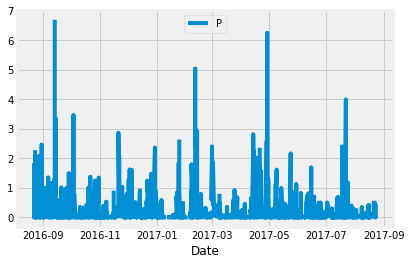

In [40]:
# This section plots the two lists to show a line graph of precipitation variation over time.

# Plot the two lists (x-value, y-value)
plt.plot(all_dates,all_precip)

# Incorporate the other graph properties
label="Precipitation"
plt.legend(label, loc=9)
plt.xlabel("Date")
plt.grid(True)


# Show plot
plt.show()

In [15]:
# This final step produces a dataframe of summary statistics of the precipitation data.

# Apply "Describe" on the precipitation dataframe and save into new dataframe.
summary_stats_describe = precip_lastyr_df.describe()

# Drop irrelevant columns and rename the precipitation field.
summary_stats_describe.drop(['id', 'tobs'], axis=1, inplace=True)
summary_stats_describe.rename(index=str, columns={"prcp": "Precipitation"}, inplace=True)

# Show Summary Stats table
summary_stats_describe

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [16]:
# For the next part of the analysis, we will analyze specific stations data. The first step is determining how...
#...stations there are.

# Find the length of the stations dataframe, which represents the number of stations. Print this result.
station_count = len(stations_df)
print(f"Number of stations in dataset: {station_count}")

Number of stations in dataset: 9


In [17]:
# Next, we will join the precepitation dataframe (derived from Measurements) with the Stations dataframe so that...
#...we have access to all of the measurement data alongside its corresponding station name and attributes.

# Perform an outer merge the two dataframes on the "station" field.
join_df = pd.merge(precip_lastyr_df, stations_df, on='station', how='outer')
join_df.head()

,id_x,station,date,prcp,tobs,id_y,name,latitude,longitude,elevation
0,19550.0,USC00516128,2017-08-23,0.45,76.0,9,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
1,19549.0,USC00516128,2017-08-22,0.50,76.0,9,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
2,19548.0,USC00516128,2017-08-21,0.56,76.0,9,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
3,19547.0,USC00516128,2017-08-20,NaN,78.0,9,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
4,19546.0,USC00516128,2017-08-19,0.09,71.0,9,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4


In [18]:
# With the dataframes joined, next we will calculate the number of measurements at each station using a...
#...GroupBy operation.

# Groupby the "name" field and return the count of records.
active_stations = join_df.groupby("name").count()

# Rename the final columns, sort by measurements (descending), drop irrelevant columns, and show final table.
active_stations_final = active_stations.rename(index=str, columns={"name": "Station Name", "id_x": "Number of Measurements"})
active_stations_final.sort_values("Number of Measurements", ascending=False, inplace=True)
active_stations_final.drop(['date', 'prcp', 'tobs', 'station', 'id_y', 'longitude', 'latitude', 'elevation'], axis=1, inplace=True)
active_stations_final.head(9)

,Number of Measurements
name,
"WAIKIKI 717.2, HI US",361
"WAIHEE 837.5, HI US",352
"MANOA LYON ARBO 785.2, HI US",349
"KANEOHE 838.1, HI US",343
"WAIMANALO EXPERIMENTAL FARM, HI US",337
"KUALOA RANCH HEADQUARTERS 886.9, HI US",305
"PEARL CITY, HI US",183
"HONOLULU OBSERVATORY 702.2, HI US",0
"UPPER WAHIAWA 874.3, HI US",0


In [19]:
# The previous analysis shows that "WAIKIKI 717.2, HI US" station had the most recorded measurements. Using this...
#...station, we will calculate the minimum, maximum, and average temperatures recorded at this site.

# Store the first station's data listing from the ordered table (WAIKIKI 717.2, HI US)
first_station = active_stations_final.index[0]

# Print out the min, max, and mean of the "tobs" field from the full dataset WHERE the station name is ...
#...WAIKIKI 717.2, HI US.
first_station_min = join_df[(join_df["name"] == first_station)]["tobs"].min()
print(f"The minimum temperature recorded at {first_station} is {first_station_min} degrees fahrenheit.")
first_station_max = join_df[(join_df["name"] == first_station)]["tobs"].max()
print(f"The maximum temperature recorded at {first_station} is {first_station_max} degrees fahrenheit.")
first_station_mean = join_df[(join_df["name"] == first_station)]["tobs"].mean()
print(f"The average temperature recorded at {first_station} is {first_station_mean} degrees fahrenheit.")

The minimum temperature recorded at WAIKIKI 717.2, HI US is 60.0 degrees fahrenheit.
The maximum temperature recorded at WAIKIKI 717.2, HI US is 87.0 degrees fahrenheit.
The average temperature recorded at WAIKIKI 717.2, HI US is 75.21052631578948 degrees fahrenheit.


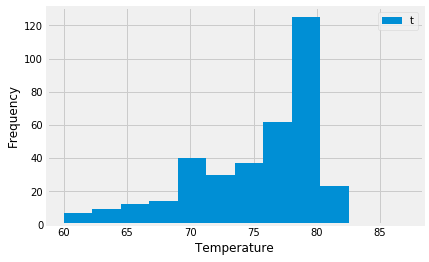

In [38]:
# The final step in the analysis is to create a histogram of the station's temperature data. After filtering...
#..from the joined dataframe to select only data from Waikiki station, I then visualize the data in a histogram.

# From the last year of data, filter out only data recorded at Station USC00519281 ({first_station}).
join_df2 = join_df[join_df["name"] == first_station]
join_df2.head()

# Create a histogram that charts the frequency of temperatures in data from Waikiki over the last year of data.
# Convert the temperature dataframe column into a list and establish 12 bins
temps = join_df2["tobs"].tolist()
bins = 12

# Create the histogram and set parameters.
plt.hist(temps,bins)
plt.legend("tobs", loc='best')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()
